In [4]:
# prepare_data_for_eda.py scrip, without saving out to pkl or csv
import numpy as np
import os
import pandas as pd
import logging.config
import matplotlib.pyplot as plt
import numpy as np
import operator

from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import importlib

from sklearn.tree import DecisionTreeRegressor, export_graphviz 
import category_encoders as ce

LOGGING_CONFIG = os.getenv('LOGGING_CONFIG')
logging.config.fileConfig(LOGGING_CONFIG)
logger = logging.getLogger('prepare_data_for_eda')

import statsmodels.api as sm

In [5]:
DATADIR = os.getenv('DATADIR')
logger.info("using DATADIR {}".format(DATADIR))
ENGINE = os.getenv('ENGINE')
logger.info("using data from {}".format(ENGINE))

In [6]:
#accurate_proportions.to_csv(os.path.join(DATADIR, 'accurate_proportions.csv.gz'), compression='gzip')
accurate_proportions = pd.read_csv('../DATA/accurate_proportions.csv')

### regression- GLM binomial response data

In [7]:
y_usefulness = accurate_proportions[['is_this_useful_yes','is_this_useful_no']].values


In [8]:
y_usefulness.shape

(575, 2)

In [9]:
x_vars = accurate_proportions[['spelling_grammar', 'errors', 'style', 'string_length', 'word_count', 'sentence_count']]

In [10]:
glm_binom = sm.GLM(y_usefulness, x_vars, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  575
Model:                            GLM   Df Residuals:                      569
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -34804.
Date:                Thu, 31 May 2018   Deviance:                       66218.
Time:                        10:00:33   Pearson chi2:                 1.05e+03
No. Iterations:                     5                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
spelling_grammar    -5.9683      0.410    -14.575      0.000      -6.771      -5.166
errors              15.7882      0

In [11]:
print("over_f = {}".format(66218/569))

over_f = 116.37609841827768


It is assumed that the residual deviance is the same as the residual degrees of freedom. If the residual deviance is larger than the residual degrees of freedom, this is called overdispersion. It means that there is extra unexplained vairation, over and above the binomial variance assumed by the model specification. 

This model is not sound, the overdisperison factor is over_f. The simplest way to take this into account is to use an 'empirical scale parameter' to reflect the fact that the errors are not binomial as well assumed but are lager than this (overdispersed) by a facotr of over_f. We refit the model using quasibinomial to account for overdispersion. 

This can't be done, obviously in statsmodels library so check the R script for quasibinomial GLM

### Data preprocessing pipeline

In [75]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [76]:
num_attribs = [ 'feedex_comments',
       'number_of_internal_searches', 'exits', 'entrances', 'bounce_rate',
       'avg_time_on_page',  'number_of_pdfs',   'number_of_word_files', 
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
        'total_to_unique_pageviews',
       'feedex_per_unique_1000', 'searches_per_pageview_1000'
       ]

In [77]:
cat_attribs = [ 'document_type',
       'content_purpose_document_supertype', 'status',
       'primary_organisation_title', 
       'primary_organisation_withdrawn',  'locale']

In [85]:
num_pipeline = Pipeline( [
            ('selector', DataFrameSelector(num_attribs)),
            ('imputer', Imputer(strategy='median')),
            ('min_max_scaler', MinMaxScaler()),
            ])

In [86]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('one_hot_encoder', ce.OneHotEncoder(drop_invariant=True)),
        ])

In [87]:
cat_pipeline.named_steps['one_hot_encoder']

OneHotEncoder(cols=None, drop_invariant=True, handle_unknown='impute',
       impute_missing=True, return_df=True, verbose=0)

In [88]:
le = LabelEncoder()
le.fit(accurate_proportions['primary_organisation_title'].fillna('unknown'))
le.classes_


array(['Cabinet Office', 'Civil Service', 'Civil Service Resourcing',
       'Department for Education',
       'Department for Exiting the European Union',
       'Department for Work and Pensions',
       'Department of Health and Social Care',
       'Disclosure and Barring Service',
       'Driver and Vehicle Licensing Agency',
       'Driver and Vehicle Standards Agency',
       'Foreign & Commonwealth Office', 'HM Passport Office',
       'HM Revenue & Customs', 'HM Treasury', 'Highways England',
       'Home Office', "Prime Minister's Office, 10 Downing Street",
       'Standards and Testing Agency', 'UK Visas and Immigration',
       'Valuation Office Agency', 'unknown'], dtype=object)

In [89]:
full_pipeline = Pipeline([
        ('features', FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
]))])

In [90]:
x_vars_prepared = full_pipeline.fit_transform(accurate_proportions)

In [91]:
x_vars_prepared.shape

(575, 100)

In [92]:
x_vars_prepared[1]

array([9.25737350e-06, 1.60505459e-04, 6.44091499e-03, 9.25206211e-03,
       6.37440758e-01, 2.05323798e-01, 0.00000000e+00, 0.00000000e+00,
       8.45298281e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.33333333e-02, 3.58422939e-02, 0.00000000e+00, 0.00000000e+00,
       4.76190476e-03, 3.85964912e-02, 2.57668871e-02, 1.54639175e-02,
       2.50347705e-02, 6.69568129e-04, 7.60589521e-02, 7.44731520e-02,
       1.88445043e-02, 1.07953199e-04, 3.44843561e-02, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [98]:
fixable_vars =  [ 'number_of_pdfs',   'number_of_word_files', 
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count'
       ]

fixable_pipeline = Pipeline( [
            ('selector', DataFrameSelector(fixable_vars)),
            ('imputer', Imputer(strategy='median')),
            ('min_max_scaler', MinMaxScaler()),
            ])

fixable_vars_prepared = fixable_pipeline.fit_transform(accurate_proportions)

In [99]:
accurate_proportions['profanities_count'].describe()

count    457.000000
mean       3.695842
std       14.612894
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max      279.000000
Name: profanities_count, dtype: float64

### Decision tree

In [100]:
tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(x_vars_prepared, accurate_proportions['useful_per_responses'])

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [101]:
fixable_reg = DecisionTreeRegressor(max_depth=3)
fixable_reg.fit(fixable_vars_prepared, accurate_proportions['useful_per_responses'])

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### Export figure of decision tree
this can be converted to png in cmd line  
`dot -Tpng fixable_tree.dot -o fixable_tree.png`

In [102]:
export_graphviz(
    fixable_reg, 
    out_file='../DATA/fixable_tree.dot', 
    feature_names=fixable_vars
)

#### Feature importance

In [103]:
for name, score in sorted(dict(zip(fixable_vars, 
                        fixable_reg.feature_importances_)).items(), key=operator.itemgetter(1), reverse=True):
    print(name, score)

contractions_count 0.31039802754208184
profanities_count 0.29638917944990695
simplify_count 0.22171845471268478
spell_count 0.17149410100091556
repeated_words_count 2.3729441083821582e-07
number_of_pdfs 0.0
number_of_word_files 0.0
readability_score 0.0
equality_count 0.0
indefinite_article_count 0.0
passive_count 0.0
redundant_acronyms_count 0.0
string_length 0.0
sentence_count 0.0
word_count 0.0


In [32]:
#This names the categorical features but I actually want the names of the levels so it's not ideal
cat_names=[]
for x in list(cat_pipeline.fit_transform(accurate_proportions).columns):
    for y, feature_name in enumerate(cat_attribs):
        
        if (y==int(x.split('_')[0])):
            cat_names.append(feature_name + '_' + x.split('_')[1])
        

In [33]:
export_graphviz(
    tree_reg, 
    out_file='../DATA/decision_tree.dot', 
    feature_names=num_attribs + cat_names
)

In [34]:
tree_reg.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.13721041,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03582745, 0.        ,
       0.        , 0.        , 0.        , 0.0921258 , 0.        ,
       0.        , 0.        , 0.        , 0.17937261, 0.0543851 ,
       0.        , 0.42859021, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [35]:
x_vars_labels = num_attribs + cat_names

In [36]:
for name, score in sorted(dict(zip(num_attribs + cat_names, 
                        tree_reg.feature_importances_)).items(), key=operator.itemgetter(1), reverse=True):
    print(name, score)

searches_per_pageview_1000 0.42859020683079907
response_per_unique_pageview 0.17937261084980866
bounce_rate 0.1372104127318815
string_length 0.09212580159188367
primary_organisation_title_5 0.07248842031608188
total_to_unique_pageviews 0.05438509692506211
profanities_count 0.03582745075448303
feedex_comments 0.0
number_of_internal_searches 0.0
exits 0.0
entrances 0.0
avg_time_on_page 0.0
number_of_pdfs 0.0
number_of_word_files 0.0
readability_score 0.0
contractions_count 0.0
equality_count 0.0
indefinite_article_count 0.0
passive_count 0.0
redundant_acronyms_count 0.0
repeated_words_count 0.0
simplify_count 0.0
spell_count 0.0
sentence_count 0.0
word_count 0.0
count_survey_responses 0.0
response_per_pageview 0.0
feedex_per_unique_1000 0.0
document_type_0 0.0
document_type_1 0.0
document_type_2 0.0
document_type_3 0.0
document_type_4 0.0
document_type_5 0.0
document_type_6 0.0
document_type_7 0.0
document_type_8 0.0
document_type_9 0.0
document_type_10 0.0
document_type_11 0.0
document_

### Gradient boosted random forest

In [38]:
X_train, X_val, y_train, y_val = train_test_split(x_vars_prepared, accurate_proportions['useful_per_responses'])

In [57]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=17)

In [58]:
#This is adapted from hands-on machine learning with scikit-learn and tensorflow
#Increase by one tree each time and get error, if error going down continue, otherwise wait for 5 trees then stop

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [105]:
#% error in usefulness estimate at stopping
np.sqrt(val_error)

0.16566221778114618

In [70]:
val_error

0.027443970400167904

In [60]:
np.mean(accurate_proportions['useful_per_responses'])

0.5099938579366516

typical prediction error of 17%

In [63]:
gbrt

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=57, presort='auto', random_state=17,
             subsample=1.0, verbose=0, warm_start=True)

In [64]:
params = {'n_estimators': 57, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

In [65]:
np.zeros((params['n_estimators'],), dtype=np.float64)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [106]:
#Also see handson machinel elarning text book
#Instead of just ealry stopping, keep all results until stop so error can be plotted over trees

# deviance = MSE = ._loss
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
error = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbrt.staged_predict(X_val)): #number of iterations staged_predict(X)	Predict regression target at each stage for X.
    test_score[i] = gbrt.loss_(y_val, y_pred) #'loss': ‘ls’ refers to least squares regression
    error[i] = mean_squared_error(y_val, y_pred)
    
    if test_score[i] != error[i]:
        print("they're different")


In [67]:
X_val.shape

(144, 100)

In [68]:
gbrt.train_score_.shape

(57,)

Text(0,0.5,'MSE')

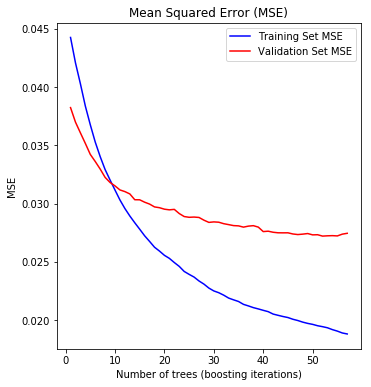

In [69]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbrt.staged_predict(X_val)): #number of iterations staged_predict(X)	Predict regression target at each stage for X.
    test_score[i] = gbrt.loss_(y_val, y_pred) #'loss': ‘ls’ refers to least squares regression

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Mean Squared Error (MSE)')
plt.plot(np.arange(params['n_estimators']) + 1, gbrt.train_score_, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Number of trees (boosting iterations)')
plt.ylabel('MSE')

In [114]:
# Plot feature importance
feature_importance = gbrt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Needs correcting to sort labels 
# plt.subplot(1, 2, 2)
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, x_vars_labels) # Think ths is an error becaise labels are not getting sroted
# plt.xlabel('Relative Importance')
# plt.title('Variable Importance')
# plt.show()

In [113]:
for name, score in sorted(dict(zip(x_vars_labels, 
                        feature_importance)).items(), key=operator.itemgetter(1), reverse=True):
    print(name, score)

searches_per_pageview_1000 100.0
bounce_rate 62.78396627829191
number_of_internal_searches 49.391551592295066
response_per_unique_pageview 41.82157190409575
profanities_count 39.94161427177248
feedex_per_unique_1000 28.34345376061626
total_to_unique_pageviews 25.72432194304215
feedex_comments 24.40036602858406
avg_time_on_page 20.60974599809924
sentence_count 14.624463200134095
contractions_count 13.882683845109092
document_type_12 11.664239203553464
count_survey_responses 11.525564929020431
document_type_5 11.364167151269623
response_per_pageview 10.694599262121612
simplify_count 9.956243888960786
string_length 8.807864940730019
document_type_21 8.596630457454388
primary_organisation_title_10 8.2376624735847
exits 8.13229673521578
number_of_pdfs 5.175815007149762
document_type_31 5.157112927826344
entrances 4.894965784384077
primary_organisation_title_18 4.44293015464239
primary_organisation_title_5 4.090120610065264
document_type_4 3.953753685823083
primary_organisation_title_4 3.544

In [108]:
for name, score in sorted(dict(zip(num_attribs + cat_names, 
                        gbrt.feature_importances_)).items(), key=operator.itemgetter(1), reverse=True):
    print(name, score)

searches_per_pageview_1000 0.18239239478774233
bounce_rate 0.1145131796377052
number_of_internal_searches 0.09008643377201024
response_per_unique_pageview 0.07627936653375784
profanities_count 0.0728504667871685
feedex_per_unique_1000 0.05169630407954441
total_to_unique_pageviews 0.04691920683482327
feedex_comments 0.044504411936509204
avg_time_on_page 0.037590609285604086
sentence_count 0.026673908655576672
contractions_count 0.025320959525905504
document_type_12 0.021274685217131845
count_survey_responses 0.02102175388685652
document_type_5 0.020727376614882623
response_per_pageview 0.019506135707135826
simplify_count 0.018159431659983828
string_length 0.01606487579506744
document_type_21 0.015679600162403506
primary_organisation_title_10 0.015024869860102307
exits 0.014832690766605447
number_of_pdfs 0.009440292941323807
document_type_31 0.009406181770970723
entrances 0.008928045318178713
primary_organisation_title_18 0.008103566707799
primary_organisation_title_5 0.00746006893040505